# Setiment Analysis with BERT

## Installing Dependencies

In [1]:
!pip install -U "tensorflow-text==2.13.*"

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.5/6.5 MB 56.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 479.7/479.7 MB 2.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 90.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.3/17.3 MB 75.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.6/5.6 MB 87.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 440.8/440.8 kB 50.0 MB/s eta 0:00:00
INFO: pip is looking at multiple versions of tf-keras to determine which version is compatible with other requirements. This could take a while.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 77.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 92.6 MB/s eta 0:00:00
  Attempting uninstall: typing-extensions
    Found existing installation: typing_extensions 4.11.0
    Uninstalling typing_extensions-4.11.0:
      Successfully uninstalled typing_extensions-4.11.0
  Attempting un

In [2]:
!pip install "tf-models-official==2.13.*"

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.6/2.6 MB 33.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.7/106.7 kB 15.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.6/43.6 kB 6.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 242.5/242.5 kB 29.7 MB/s eta 0:00:00
  Created wheel for seqeval: filename=seqeval-1.2.2-py3-none-any.whl size=16161 sha256=abeaedfb4c2bbcf1f099a73691058bc7af579b9002caff80c9b8cb60ce534a94
  Stored in directory: /root/.cache/pip/wheels/1a/67/4a/ad4082dd7dfc30f2abfe4d80a2ed5926a506eb8a972b4767fa
Successfully built seqeval


## Importing Required Modules

In [3]:
import os
import shutil
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text as text
from official.nlp import optimization
import matplotlib.pyplot as plt

tf.get_logger().setLevel('ERROR')

In [4]:
url = "https://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz"

dataset = tf.keras.utils.get_file("aclImdb_v1", url, untar=True, cache_dir='.', cache_subdir='')

dataset_dir = os.path.join(os.path.dirname(dataset), 'aclImdb')
train_dir = os.path.join(dataset_dir,"train")

# removing unused folders to facilitate loading the data
remove_dir = os.path.join(train_dir,"unsup")
shutil.rmtree(remove_dir)

84125825/84125825 [==============================] - 15s 0us/step


## Creating Training, Validation, and Test Datasets

In [5]:
AUTOTUNE = tf.data.AUTOTUNE
batch_size = 32
seed = 42

# creating training dataset
raw_train_ds = tf.keras.utils.text_dataset_from_directory(
    "aclImdb/train",
    batch_size=batch_size,
    validation_split=0.2,
    subset="training",
    seed=seed)

class_names = raw_train_ds.class_names
train_ds = raw_train_ds.cache().prefetch(buffer_size=AUTOTUNE)


# creating validation dataset
val_ds = tf.keras.utils.text_dataset_from_directory(
    "aclImdb/train",
    batch_size=batch_size,
    validation_split=0.2,
    subset="validation",
    seed=seed)


val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

# creating test dataset
test_ds = tf.keras.utils.text_dataset_from_directory(
    "aclImdb/test",
    batch_size=batch_size)

test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)


Found 25000 files belonging to 2 classes.
Using 20000 files for training.
Found 25000 files belonging to 2 classes.
Using 5000 files for validation.
Found 25000 files belonging to 2 classes.


In [6]:
# few review from dataset
for text_batch, label_batch in train_ds.take(1):
  for i in range(3):
    print(f"Review: {text_batch.numpy()[i]}")
    label = label_batch.numpy()[i]
    print(f"label: {label} ({class_names[label]})")

Review: b'"Pandemonium" is a horror movie spoof that comes off more stupid than funny. Believe me when I tell you, I love comedies. Especially comedy spoofs. "Airplane", "The Naked Gun" trilogy, "Blazing Saddles", "High Anxiety", and "Spaceballs" are some of my favorite comedies that spoof a particular genre. "Pandemonium" is not up there with those films. Most of the scenes in this movie had me sitting there in stunned silence because the movie wasn\'t all that funny. There are a few laughs in the film, but when you watch a comedy, you expect to laugh a lot more than a few times and that\'s all this film has going for it. Geez, "Scream" had more laughs than this film and that was more of a horror film. How bizarre is that?<br /><br />*1/2 (out of four)'
label: 0 (neg)
Review: b"David Mamet is a very interesting and a very un-equal director. His first movie 'House of Games' was the one I liked best, and it set a series of films with characters whose perspective of life changes as they 

## The Preprocessing Model

In [7]:
# tensorflow Hub provides a matching preprocessing models for each
# of the BERT models which implements this transformation using
# tensorflow ops from the TF.text library
bert_model_name = 'small_bert/bert_en_uncased_L-4_H-512_A-8'

map_name_to_handle = {
    'bert_en_uncased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/3',
    'bert_en_cased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_cased_L-12_H-768_A-12/3',
    'bert_multi_cased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_multi_cased_L-12_H-768_A-12/3',
    'small_bert/bert_en_uncased_L-2_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-2_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-2_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-2_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-4_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-4_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-4_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-4_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-6_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-6_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-6_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-6_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-8_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-8_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-8_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-8_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-10_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-10_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-10_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-10_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-10_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-10_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-10_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-10_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-12_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-12_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-12_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-768_A-12/1',
    'albert_en_base':
        'https://tfhub.dev/tensorflow/albert_en_base/2',
    'electra_small':
        'https://tfhub.dev/google/electra_small/2',
    'electra_base':
        'https://tfhub.dev/google/electra_base/2',
    'experts_pubmed':
        'https://tfhub.dev/google/experts/bert/pubmed/2',
    'experts_wiki_books':
        'https://tfhub.dev/google/experts/bert/wiki_books/2',
    'talking-heads_base':
        'https://tfhub.dev/tensorflow/talkheads_ggelu_bert_en_base/1',
}

map_model_to_preprocess = {
    'bert_en_uncased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'bert_en_cased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_cased_preprocess/3',
    'small_bert/bert_en_uncased_L-2_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-2_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-2_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-2_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-4_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-4_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-4_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-4_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-6_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-6_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-6_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-6_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-8_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-8_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-8_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-8_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-10_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-10_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-10_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-10_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-12_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-12_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-12_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'bert_multi_cased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_multi_cased_preprocess/3',
    'albert_en_base':
        'https://tfhub.dev/tensorflow/albert_en_preprocess/3',
    'electra_small':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'electra_base':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'experts_pubmed':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'experts_wiki_books':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'talking-heads_base':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
}

tfhub_handle_encoder = map_name_to_handle[bert_model_name]
tfhub_handle_preprocess = map_model_to_preprocess[bert_model_name]

print(f'BERT model selected           : {tfhub_handle_encoder}')
print(f'Preprocess model auto-selected: {tfhub_handle_preprocess}')

BERT model selected           : https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-512_A-8/1
Preprocess model auto-selected: https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3


In [8]:
bert_preprocess_model = hub.KerasLayer(tfhub_handle_preprocess)

In [9]:
# trying preprocessing on some text
text_test = ["thisis such a amazing movie!"]
text_preprocessed = bert_preprocess_model(text_test)

print(f"Keys       : {list(text_preprocessed.keys())}")
print(f'Shape      : {text_preprocessed["input_word_ids"].shape}')
print(f'Word Ids   :{text_preprocessed["input_word_ids"][0,:12]}')
print(f'Input Mask : {text_preprocessed["input_mask"][0,:12]}')
print(f'Type Ids   : {text_preprocessed["input_type_ids"][0,:12]}')

Keys       : ['input_word_ids', 'input_type_ids', 'input_mask']
Shape      : (1, 128)
Word Ids   :[ 101 2023 2483 2107 1037 6429 3185  999  102    0    0    0]
Input Mask : [1 1 1 1 1 1 1 1 1 0 0 0]
Type Ids   : [0 0 0 0 0 0 0 0 0 0 0 0]


## Defining Model

In [10]:
# loading model from tensorflow hub
bert_model = hub.KerasLayer(tfhub_handle_encoder)

In [11]:
bert_results = bert_model(text_preprocessed)

print(f"Loaded BERT: {tfhub_handle_encoder}")
print(f"Pooled Outputs Shape: {bert_results['pooled_output'].shape}")
print(f"Pooled Outputs Values: {bert_results['pooled_output'][0,: 12]}")
print(f"Sequence Outputs Shape: {bert_results['sequence_output'].shape}")
print(f"Sequence Outputs Values: {bert_results['sequence_output'][0, :12]}")

Loaded BERT: https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-512_A-8/1
Pooled Outputs Shape: (1, 512)
Pooled Outputs Values: [ 0.6999778   0.9970435  -0.21794893  0.30951563  0.3361489   0.85332686
  0.954814   -0.95675254  0.14669842 -0.99070513  0.0277494  -0.9674645 ]
Sequence Outputs Shape: (1, 128, 512)
Sequence Outputs Values: [[-0.4304939   0.26109967  0.16052192 ... -0.24751958  0.8421327
  -0.15054873]
 [-0.65464824  0.53027505 -0.12098381 ...  0.7919955  -0.07384456
   0.02600576]
 [-0.70340437  0.23826012 -0.7024928  ...  0.06738822  0.42383733
   0.35833824]
 ...
 [-0.19786954 -0.17021233 -0.0764521  ...  0.3086399   0.9035844
   0.35605463]
 [-0.1836134  -0.18028802 -0.11635331 ...  0.32289565  1.2659588
   0.08163698]
 [-0.3646355  -0.032978    0.05530374 ...  0.05972642  1.3300606
  -0.05601156]]


In [12]:
def build_classifier_model():
  text_input = tf.keras.layers.Input(shape=(),dtype=tf.string,name="text")
  preprocessing_layer = hub.KerasLayer(tfhub_handle_preprocess,name="preprocessing")
  encoder_inputs = preprocessing_layer(text_input)
  encoder = hub.KerasLayer(tfhub_handle_encoder,trainable=True,name="BERT_encoder")
  outputs = encoder(encoder_inputs)
  net = outputs["pooled_output"]
  net = tf.keras.layers.Dropout(0.1)(net)
  net = tf.keras.layers.Dense(1,activation=None,name="classifier")(net)
  return tf.keras.Model(text_input,net)


In [13]:
classifier_model = build_classifier_model()
# currently output is meaningless because model is not trained yet
bert_raw_result = classifier_model(tf.constant(text_test))
print(tf.sigmoid(bert_raw_result))

tf.Tensor([[0.50269675]], shape=(1, 1), dtype=float32)


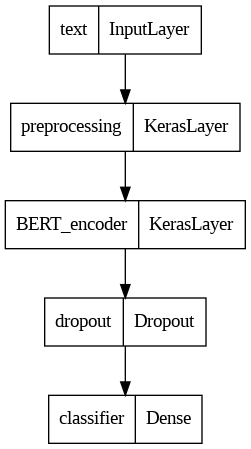

In [14]:
tf.keras.utils.plot_model(classifier_model)

## Model Training

In [16]:
!pip install tensorflow-addons


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 611.8/611.8 kB 11.6 MB/s eta 0:00:00


In [17]:
import tensorflow_addons as tfa
# since our task is a binary classification problem
# and model outputs a probability we'll use `BinaryCrossentropy` loss function
loss = tf.keras.losses.BinaryCrossentropy(from_logits=True)
metrics = [
    tf.metrics.BinaryAccuracy(),
    tf.metrics.AUC(),
    tfa.metrics.F1Score(num_classes=1, threshold=0.5),
    tf.metrics.MeanSquaredError()
]


epochs = 5
steps_per_epoch = tf.data.experimental.cardinality(train_ds).numpy()
num_train_steps = steps_per_epoch * epochs
num_warmup_steps = int(0.1*num_train_steps)

init_lr = 3e-5
optimizer = optimization.create_optimizer(init_lr,
                                          num_train_steps=num_train_steps,
                                          num_warmup_steps=num_warmup_steps,
                                          optimizer_type="adamw")

/usr/local/lib/python3.10/dist-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


## Loading BERT Model and Training

In [18]:
classifier_model.compile(optimizer=optimizer,
                         loss=loss,
                         metrics=metrics)

In [19]:
print(f"Training model with {tfhub_handle_encoder}")
history = classifier_model.fit(x=train_ds,
                               validation_data=val_ds,
                               epochs=epochs)

Training model with https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-512_A-8/1
Epoch 1/5
625/625 [==============================] - 644s 1s/step - loss: 0.4849 - binary_accuracy: 0.7429 - auc: 0.7887 - f1_score: 0.7034 - mean_squared_error: 3.1598 - val_loss: 0.3948 - val_binary_accuracy: 0.8380 - val_auc: 0.8628 - val_f1_score: 0.8456 - val_mean_squared_error: 6.8178
Epoch 2/5
625/625 [==============================] - 637s 1s/step - loss: 0.3261 - binary_accuracy: 0.8533 - auc: 0.8822 - f1_score: 0.8459 - mean_squared_error: 7.6841 - val_loss: 0.3722 - val_binary_accuracy: 0.8416 - val_auc: 0.8662 - val_f1_score: 0.8415 - val_mean_squared_error: 12.0196
Epoch 3/5
625/625 [==============================] - 635s 1s/step - loss: 0.2520 - binary_accuracy: 0.8927 - auc: 0.9149 - f1_score: 0.8888 - mean_squared_error: 11.9748 - val_loss: 0.3844 - val_binary_accuracy: 0.8506 - val_auc: 0.8677 - val_f1_score: 0.8476 - val_mean_squared_error: 15.7685
Epoch 4/5
625/625 [==========

## Evaluating Model

In [22]:
test_loss, test_mean_squared_error, test_auc, test_binary_accuracy, test_f1_score = classifier_model.evaluate(test_ds)

print(history.history.keys())

782/782 [==============================] - 222s 284ms/step - loss: 0.4640 - binary_accuracy: 0.8566 - auc: 0.8675 - f1_score: 0.8537 - mean_squared_error: 28.0744
dict_keys(['loss', 'binary_accuracy', 'auc', 'f1_score', 'mean_squared_error', 'val_loss', 'val_binary_accuracy', 'val_auc', 'val_f1_score', 'val_mean_squared_error'])


dict_keys(['loss', 'binary_accuracy', 'auc', 'f1_score', 'mean_squared_error', 'val_loss', 'val_binary_accuracy', 'val_auc', 'val_f1_score', 'val_mean_squared_error'])


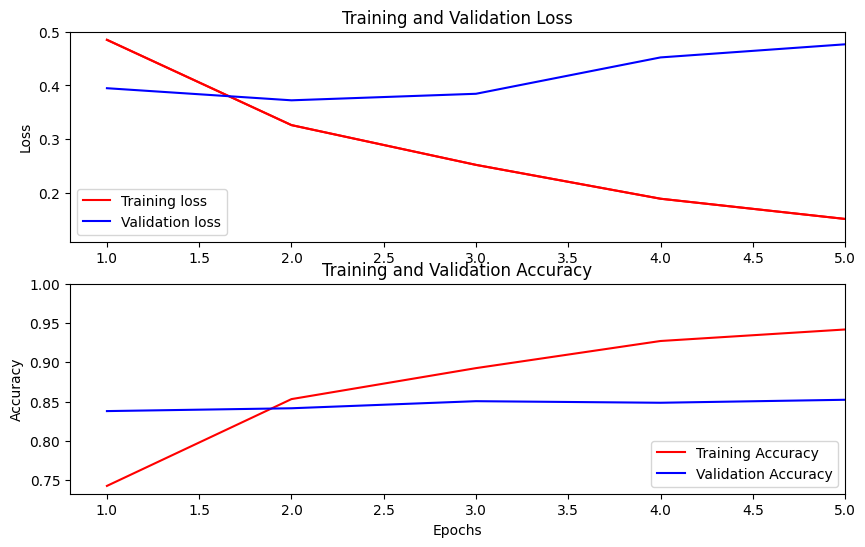

In [23]:
history_dict = history.history
print(history_dict.keys())

accuracy = history_dict["binary_accuracy"]
val_accuracy = history_dict["val_binary_accuracy"]
loss = history_dict["loss"]
val_loss = history_dict["val_loss"]

epochs = range(1,len(accuracy)+1)
fig = plt.figure(figsize=(10,6))
fig.tight_layout()

plt.subplot(2,1,1)
plt.plot(epochs,loss,"r",label)
plt.plot(epochs,loss,"r",label="Training loss")
plt.plot(epochs,val_loss,"b",label="Validation loss")
plt.title("Training and Validation Loss")
plt.ylabel("Loss")
plt.legend()
plt.ylim(min(plt.ylim()),0.5)
plt.xlim(0.8,len(epochs))

plt.subplot(2,1,2)
plt.plot(epochs,accuracy,"r",label="Training Accuracy")
plt.plot(epochs,val_accuracy,"b",label="Validation Accuracy")
plt.title("Training and Validation Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(loc="lower right")
plt.ylim(min(plt.ylim()),1)
plt.xlim(0.8,len(epochs))
plt.show()

## Exporting Model for Inference

In [24]:
# now we save our fine-tuned model for later use
dataset_name = "imdb"
saved_model_path = "./{}_bert".format(dataset_name.replace("/","_"))

classifier_model.save(saved_model_path,include_optimizer=False)

In [25]:
# reloading model
reloaded_model = tf.saved_model.load(saved_model_path)

In [26]:
def print_my_examples(inputs,results):
  result_for_printing = [f"input: {inputs[i]:<30} : score: {results[i][0]:.6f}" for i in range(len(inputs))]

  print(*result_for_printing,sep="\n")
  print()


# some example reviews to compare original and reloaded model
examples = [
  "this is such an amazing movie!",
  "The movie was great!",
  "The movie was meh.",
  "The movie was okish.",
  "The movie was terrible..."
]


reloaded_results = tf.sigmoid(reloaded_model(tf.constant(examples)))
original_results = tf.sigmoid(classifier_model(tf.constant(examples)))

print("Results from the saved model: ")
print_my_examples(examples,reloaded_results)
print("Results from the model in memory: ")
print_my_examples(examples,original_results)


Results from the saved model: 
input: this is such an amazing movie! : score: 0.999410
input: The movie was great!           : score: 0.991680
input: The movie was meh.             : score: 0.914812
input: The movie was okish.           : score: 0.060229
input: The movie was terrible...      : score: 0.000810

Results from the model in memory: 
input: this is such an amazing movie! : score: 0.999410
input: The movie was great!           : score: 0.991680
input: The movie was meh.             : score: 0.914812
input: The movie was okish.           : score: 0.060229
input: The movie was terrible...      : score: 0.000810

